In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [5]:
only_mouse = False
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)

def load_and_process_data(directory_path, part_of_file_name):
    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    print(fileIs.split('_')[2] )
    # extract the necessary data
    if only_mouse:
        sigma, dynamicSigma, confRate,target = mat_contents['sigma'], mat_contents['dynamicSigma'], mat_contents['mouse_y'], mat_contents['blob_x']
        eyeResp = None
    elif fileIs.split('_')[2] == "both":
        sigma, dynamicSigma, confRate,target,eyeResp = mat_contents['sigma'], mat_contents['dynamicSigma'],mat_contents['mouse_y'], mat_contents['blob_x'], mat_contents['eyeX']
        targetY = mat_contents['blob_y']
        eyeRespY=mat_contents['eyeY']
        confRate=confRate-np.mean(confRate, axis=1, keepdims=True)
        combinedEyeRespXY = np.sqrt(eyeResp**2 +eyeRespY**2)
        combinedTargetPosXY = np.sqrt(target**2 +targetY**2)

    elif fileIs.split('_')[2] == "eye":
        sigma, dynamicSigma,target,eyeResp = mat_contents['sigma'], mat_contents['dynamicSigma'], mat_contents['blob_x'], mat_contents['eyeX']
        confRate = dynamicSigma
        targetY = mat_contents['blob_y']
        eyeRespY=mat_contents['eyeY']
        confRate=confRate-np.mean(confRate, axis=1, keepdims=True)
        combinedEyeRespXY = np.sqrt(eyeResp**2 +eyeRespY**2)
        combinedTargetPosXY = np.sqrt(target**2 +targetY**2)
    
    mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[2] == "both" else None
    if mouseResp is not None:
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)


    

    # """ Select specific rows from the matrices """
    sigma=sigma.flatten()
    # if len(sigma) > 15:
    #     matrices = [sigma, dynamicSigma, confRate, target, eyeResp]
    #     # Create an empty list to store the results
    #     selected_rows_list = []
    #     for matrix in matrices:
    #         selected_rows = np.concatenate([matrix[0:2], matrix[5:7], matrix[9:11], matrix[14:16], matrix[19:21]], axis=0)
    #         selected_rows_list.append(selected_rows)
    #     # Now selected_rows_list contains the selected rows for each matrix
    #     sigma, dynamicSigma, confRate,target,eyeResp  = selected_rows_list
    #     sigma=sigma.flatten()
    #     sigma=np.concatenate([sigma[0:2], sigma[5:7], sigma[9:11], sigma[14:16], sigma[19:21]], axis=0)
    # ### selection done


    eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
    targetY = targetY - np.mean(targetY, axis=1, keepdims=True)
    eyeRespY = eyeRespY - np.mean(eyeRespY, axis=1, keepdims=True)
    combinedEyeRespXY = combinedEyeRespXY - np.mean(combinedEyeRespXY, axis=1, keepdims=True)
    combinedTargetPosXY = combinedTargetPosXY - np.mean(combinedTargetPosXY, axis=1, keepdims=True)

    eyeResp = smooth_data(eyeResp)
    eyeRespY = smooth_data(eyeRespY)
    combinedEyeRespXY=smooth_data(combinedEyeRespXY)





    dynamicSigma=dynamicSigma-np.mean(dynamicSigma, axis=1, keepdims=True)
    # # Normalize the signals
    def min_max_normalizer(x):
        return ((x-x.min())/(x.max()-x.min()))*2-1
    confRateReal = confRate
    dynamicSigmaReal = dynamicSigma
    #confRate = min_max_normalizer(confRate)
    #dynamicSigma = min_max_normalizer(dynamicSigma)
    
    # # Z score of confRate and dynamicSigma
    # confRateReal = confRate
    # dynamicSigmaReal = dynamicSigma
    confRate = (confRate - confRate.mean()) / confRate.std()
    dynamicSigma = (dynamicSigma - dynamicSigma.mean()) / dynamicSigma.std()

    # sigma=sigma.flatten()
    sigma = np.where(sigma == 2.35, '23.5_short', sigma)    
    sigma = np.where(sigma == '23.5', '23.5_normal', sigma)
    sigma = np.where(sigma == '235.0', '23.5_long', sigma)
    
    # revert dynamicSigma 1-DynamicSigma
    #dynamicSigma = dynamicSigma.flatten()
    dynamicSigma=1-dynamicSigma
    blob_widths = np.unique(sigma)
    nTrial = len(sigma)
    nSigma = len(blob_widths)#(nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma
    
    print(nTrial, nSigma, nTrialPerSigma, blob_widths)

    return fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY


fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data("dataMeta_eye", "p10_eye")
#sigma = np.delete(sigma, 14)

blob_widths = np.unique(sigma)
#print(dynamicSigma[0].max())
# calculate the number of trials
nTrial = len(sigma)
nSigma = len(blob_widths)#(nTrial - 1) // 5 + 1

nTrialPerSigma = nTrial // nSigma



eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']


c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


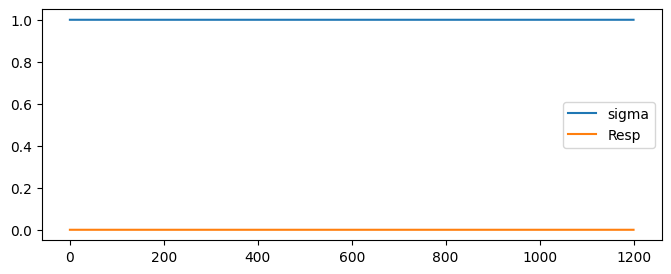

In [6]:

#Plot Data
trialNum=2

plt.figure(figsize=(8,3))
plt.plot(dynamicSigma[trialNum,:])
plt.plot(confRate[trialNum,:])
#plt.plot(target[trialNum,:])
#plt.plot(eyeResp[trialNum,:])

plt.legend(['sigma','Resp'])
plt.show()



# Dictionary for response and target

In [7]:

# plotyly plot a figure with subplots of "targetX" vs "eyeX",and "targetY vs "eyeY" using Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with subplots
fig = make_subplots(rows=1, cols=3)
# figsize
fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
)


# Add traces
trialNum=1
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=dynamicSigma[trialNum,:], mode='lines', name="dynamic sigma", line=dict(color='darkred', width=2), showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(0,1260), y=confRate[trialNum,:], mode='lines', name="confidence rating", line=dict(color='royalblue', width=2), showlegend=True), row=1, col=1)
#fig.add_trace(go.Scatter(x=np.arange(0,1260), y=targetY[trialNum,:], mode='lines', name=None, line=dict(color='darkred', width=2), showlegend=False), row=1, col=2)
#fig.add_trace(go.Scatter(x=np.arange(0,1260), y=eyeRespY[trialNum,:], mode='lines', name=None, line=dict(color='royalblue', width=2), showlegend=False), row=1, col=2)
#fig.add_trace(go.Scatter(x=target[trialNum,:], y=targetY[trialNum,:], mode='lines', name='target', line=dict(color='darkred', width=2)), row=1, col=3)
#fig.add_trace(go.Scatter(x=eyeResp[trialNum,:], y=eyeRespY[trialNum,:], mode='lines', name='eye', line=dict(color='royalblue', width=2)), row=1, col=3)
# Update xaxis properties
fig.update_xaxes(title_text="time(Frame)", row=1, col=1)
fig.update_xaxes(range=[-10, 1260], row=1, col=1)
fig.update_xaxes(range=[-10, 1260], row=1, col=2)
fig.update_xaxes(title_text="time(Frame)", row=1, col=2)
fig.update_xaxes(title_text="X - position", row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="time(Frame)", row=1, col=1, range=[0, 1200], dtick=200)
fig.update_xaxes(title_text="time(Frame)", row=1, col=2, range=[0, 1200], dtick=200)
fig.update_xaxes(title_text="X - position", row=1, col=3, dtick=200)
# Update yaxis properties
#fig.update_yaxes(title_text="X - position", row=1, col=1)
fig.update_yaxes(title_text="Blob width change", row=1, col=1)

fig.update_yaxes(title_text="Y - position", row=1, col=2)
fig.update_yaxes(title_text="Y - position", row=1, col=3)


fig.update_layout(
    plot_bgcolor='white',
    # paper_bgcolor='black'
    # add grid
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    # grid needs to be in each subplot
    xaxis2=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis2=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    xaxis3=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)'),
    yaxis3=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')

)

# # legend name label is target, eye, mouse
fig.update_layout(legend_title_text='Legend')
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
fig.update_layout(legend=dict(orientation="h"))
# fig.update_layout(legend=dict(x=0.5, y=1.2))
# fig.update_layout(legend=dict(x=0.5, y=1.2, bgcolor='rgba(0,0,0,0)'))
# fig.update_layout(legend=dict(x=0.5, y=1.2, bgcolor='rgba(0,0,0,0)', bordercolor='black', borderwidth=2))

# # title
fig.update_layout(title_text="Target vs Response Positions", title_x=0.5, title_font_size=20, title_font_family="Arial")

fig.show()




In [8]:
len([0,1,2,5,6,7,10,11,12,15,16,17,20,21,22])

15

In [9]:
def create_sorted_trial_dict(nTrial, target, eyeResp, sigma, fileIs, mouseResp,dynamicSigma,confRate,dynamicSigmaReal,confRateReal):
    # create key-value pairs for the dictionary of 30 trials
    trial_dict = {}
    clip = 60
    selectionList=[0,1,2,5,6,7,10,11,12,15,16,17,20,21,22]
    if nTrial<150:
        for i in range(nTrial):
            trial_dict[i]={
                        'sigma': sigma[i],'blobX':target[i,clip:],
                        'eyeResp':eyeResp[i,clip:],
                        'eyeY':eyeRespY[i,clip:],
                            'targetY':targetY[i,clip:],
                                'eyeXY':combinedEyeRespXY[i,clip:],
                                    'targetXY':combinedTargetPosXY[i,clip:],


                        #'dynamicSigmaReal':dynamicSigmaReal[i,clip:],
                        #'confRateReal':confRateReal[i,clip:]
                        } #my data
            if fileIs.split('_')[2] == "both":
                #trial_dict[i]['mouseResp'] = eyeResp[i,clip:]
                #trial_dict[i]['eyeResp'] = eyeResp[i,clip:]
                trial_dict[i]['dynamicSigma']=dynamicSigma[i,clip:]
                trial_dict[i]['confResp']=confRate[i,clip:]
            
    # if nTrial>15:
    #     selectionList=[0,1,2,5,6,7,10,11,12,15,16,17,20,21,22]
    #     trial_dict={}
    #     clip=60
    #     for n in range(len(selectionList)):
    #         i=selectionList[n]
    #         trial_dict[i]={
    #                        'sigma': sigma[i],'blobX':target[i,clip:],
    #                        'eyeResp':eyeResp[i,clip:],
    #                        'eyeY':eyeRespY[i,clip:],
    #                           'targetY':targetY[i,clip:],
    #                             'eyeXY':combinedEyeRespXY[i,clip:],
    #                                 'targetXY':combinedTargetPosXY[i,clip:],


    #                        #'dynamicSigmaReal':dynamicSigmaReal[i,clip:],
    #                        #'confRateReal':confRateReal[i,clip:]
    #                        }
    #         if fileIs.split('_')[2] == "both":
    #             #trial_dict[i]['mouseResp'] = eyeResp[i,clip:]
    #             #trial_dict[i]['eyeResp'] = eyeResp[i,clip:]
    #             trial_dict[i]['dynamicSigma']=dynamicSigma[i,clip:]
    #             trial_dict[i]['confResp']=confRate[i,clip:]



    # sort the dictionary by sigma
    trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
    tmp_trial = trialDictSorted[0][1]

    return trialDictSorted, tmp_trial
fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data("dataMeta_both", "p1_both")

trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
                                                      mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)



both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']


## - Avarage CCG across different blob widths for single participant

both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp'])


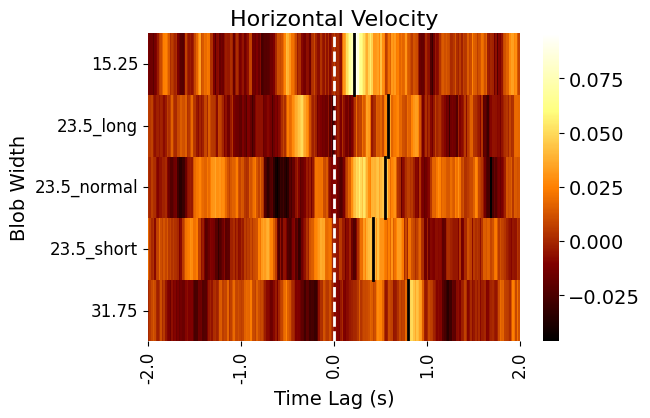

(15, 2279)
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])
dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])


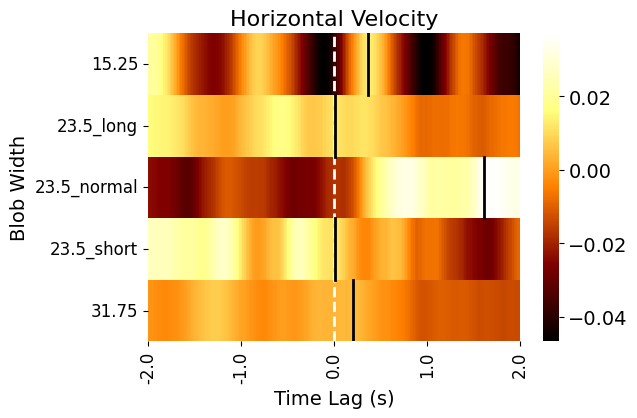

<module 'matplotlib.pyplot' from 'C:\\Users\\omeru\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

In [101]:
# # process CCG for eye response and target 
ccgMethod='full'
plotName='Horizontal'
eye_results = True
if eye_results==True:
    iv = 'eyeResp'
    dv = 'blobX'
else:
    iv = 'confResp'
    dv = 'dynamicSigma'

respMode = 'mouse_y'
# Now you can use these functions in your main code
frameRate = 60
if eye_results:
    timeDelay=2
else:
    timeDelay=2.5
#timeDelay = 2
#nTrialPerSigma = 2
lag_time = timeDelay

lag_range = int(lag_time * frameRate)
len_trial = len(trialDictSorted[0][1]['blobX'])

def calculate_ccg(X, Y):
    if confCCG:
        #X = np.diff(X)
        #Y = np.diff(Y)
        X = (X - np.mean(X)) / np.std(X) # take the z-score of the data
        Y = (Y - np.mean(Y)) / np.std(Y) # take the z-score of the data
        ccg = np.correlate(X, Y, ccgMethod) # use 'same' mode

    else:
        X = np.diff(X)
        Y = np.diff(Y)
        X = (X - np.mean(X)) / np.std(X) # take the z-score of the data
        Y = (Y - np.mean(Y)) / np.std(Y) # take the z-score of the data
        ccg = np.correlate(X, Y, ccgMethod) # use 'same' mode
    return ccg / (len(X) * np.std(X) * np.std(Y))

def calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma, DV="None",IV="None"):
    print(trialDictSorted[0][1].keys())

    ccg_single_blobs = []
    for i in range(nTrialPerSigma):
        tmp_trial = trialDictSorted[i + blob_width * nTrialPerSigma][1]
        X = tmp_trial[IV]
        Y = tmp_trial[DV]
        ccg_single_trial = calculate_ccg(X, Y)
        ccg_single_blobs.append(ccg_single_trial)
    return ccg_single_blobs

def calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma, DV="None",IV="None"):
    ccg_single_blob = []
    ccg_blob_mean = []
    for blob_width in range(len(blob_widths)):
        ccg_single_blobs = calculate_ccgs_for_blob_width(trialDictSorted, blob_width, nTrialPerSigma, DV, IV)
        ccg_single_blob.append(ccg_single_blobs)
        ccg_blob_mean.append(np.mean(ccg_single_blob[blob_width], axis=0))
    return ccg_blob_mean, ccg_single_blob

def trim_ccgs(ccgs, len_trial, lag_range):
    ccgs = np.array(ccgs)
    return ccgs[:, len_trial - lag_range : len_trial + lag_range]

def plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot', yticklabels=blob_widths)
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='vertical', fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(plotName+' Velocity', fontsize=16)
    plt.xlabel('Time Lag (s)', fontsize=14)
    plt.ylabel('Blob Width', fontsize=14)
    plt.axvline(x=lag_range, color='white', linestyle='--', linewidth=2)
    return plt

def plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_range):
    plt.figure(figsize=(6, 4))
    sns.heatmap(ccg_single_trials_trimmed, cmap='afmhot')
    x = np.linspace(0, frameRate * lag_time * 2, 5)
    labels = np.linspace(-lag_time, lag_time, len(x))
    plt.xticks(x, labels, rotation='horizontal', fontsize=12)
    yticks=np.linspace(0, len(ccg_single_trials_trimmed), len(blob_widths))
    yticklabels=blob_widths
    plt.yticks(yticks, yticklabels,rotation='horizontal' ,fontsize=12)
    plt.title(str(plotName)+' Velocity', fontsize=16)
    plt.xlabel('Time Lag (s)', fontsize=14)
    plt.ylabel('Blob Width', fontsize=14)
    return plt
def find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths):
    timePoints = ccg_blob_mean_trimmed.shape[1]
    ccg_blob_mean_trimmed=ccg_blob_mean_trimmed[:,timePoints//2:]

    peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
    #peak_indices = np.where(peak_indices > timePoints // 2, peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        plt.axvline(x=peak_index+timePoints//2, color='black', linestyle='-', linewidth=2, ymin=1 - (i / len(blob_widths)), ymax=1 - ((i + 1) / len(blob_widths)))
    plt.show()




def plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths):
    plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
    find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)
    return plt


def process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, DV="None",IV="None"):
    ccg_blob_mean, ccg_single_blob = calculate_ccgs_for_all_blob_widths(trialDictSorted, blob_widths, nTrialPerSigma,DV=DV,IV=IV)
    ccg_blob_mean = np.array(ccg_blob_mean)
    ccg_blob_mean_trimmed = trim_ccgs(ccg_blob_mean, len_trial, lag_range)
    ccg_single_blob_trimmed = trim_ccgs(ccg_single_blob, len_trial, lag_range)
    ccg_single_blob = np.array(ccg_single_blob)
    ccg_single_trials = ccg_single_blob.reshape(ccg_single_blob.shape[0]*ccg_single_blob.shape[1], ccg_single_blob.shape[2])
    ccg_single_trials_trimmed = ccg_single_trials[:, len_trial - lag_range: len_trial + lag_range]
    return ccg_blob_mean_trimmed, ccg_single_trials_trimmed,ccg_blob_mean, ccg_single_blob,ccg_single_trials



#ccg_blob_mean_trimmed_type1, ccg_single_trials_trimmed_type1, ccg_blob_mean_type1, ccg_single_blob_type1,ccg_single_trials_type1= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, IV="eyeResp",DV="blobX")

# process CCG for Type2 (confResp and dynamicSigma)
#iv = 'confResp'
#dv = 'dynamicSigma'
confCCG=False

ccgMethod='full'

fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data("dataMeta_both", "p6_both_continous_psych_2024")
trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
                                                      mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)

ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, dv,iv)

# plt = plot_heatmap(ccg_blob_mean_trimmed, blob_widths, lag_range)
# find_and_plot_peak_indices(ccg_blob_mean_trimmed, blob_widths)

plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)



print(ccg_single_trials.shape)
ccg_single_trials_EYE=ccg_single_trials
#normalize the ccg
#ccg_single_trials_EYE = (ccg_single_trials_EYE - ccg_single_trials_EYE.mean(axis=1, keepdims=True)) / ccg_single_trials_EYE.std(axis=1, keepdims=True)

# process type 2 CCG Confidence rating

fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data("dataMeta_both", "p6_both_continous_psych_2024")
trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp,
                                                        mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)

# add ccg to the trial dictionary
def add_ccg_to_trials(trialDictSorted, ccg_single_trials_EYE, nTrialPerSigma):
    for i in range(nTrial):
        trialDictSorted[i][1]['ccg_eye'] = ccg_single_trials_EYE[i]
    return trialDictSorted

trialDictSorted_Updated = add_ccg_to_trials(trialDictSorted, ccg_single_trials_EYE, nTrialPerSigma)

print(trialDictSorted_Updated[0][1].keys())

# process CCG for eye response and Confidence rating
confCCG=True
dv = 'confResp'
iv='ccg_eye'
ccgMethod='full'
ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted_Updated, blob_widths, nTrialPerSigma, len_trial, lag_range, dv,iv)

plot_peaksAndHeatmap(ccg_blob_mean_trimmed, blob_widths)





In [102]:
blob_x=blob_x(a)
blob_y=blob_y(a)
dynamicSigma=dynamicSigma(a)
eyeX=eyeX(a)
eyeY=eyeY(a)
mouse_x=mouse_x(a)



NameError: name 'blob_x' is not defined

In [103]:
# # print shape of all CCGs
# print(ccg_blob_mean_trimmed_type1.shape)
# print(ccg_single_trials_trimmed_type1.shape)
# print(ccg_blob_mean_type1.shape)
# print(ccg_single_blob_type1.shape)
# print(ccg_single_blob_type1.reshape(ccg_single_blob_type1.shape[0]*ccg_single_blob_type1.shape[1], ccg_single_blob_type1.shape[2]).shape)

# print(eyeResp.shape)

# type1CCGo=ccg_single_blob_type1.reshape(ccg_single_blob_type1.shape[0]*ccg_single_blob_type1.shape[1], ccg_single_blob_type1.shape[2])
# type2CCGo=ccg_single_blob.reshape(ccg_single_blob.shape[0]*ccg_single_blob.shape[1], ccg_single_blob.shape[2])
# # add type1 and type2 CCGs to the dictionary
# print(type1CCGo.shape)
# print(type2CCGo.shape)

# trialDictSorted, tmp_trial = create_sorted_trial_dict2(nTrial, dynamicSigma, confRate, sigma, fileIs, type1CCG=type1CCGo, type2CCG=type2CCGo)



# # process and plot the CCGs for the type1 and type2
# ccg_blob_mean_trimmed_confComparison, ccg_single_trials_trimmed_confComparison, ccg_blob_mean_confComparison, ccg_single_blob_confComparison,ccg_single_trials_confComparison= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, DV="type1CCG",IV="type2CCG")


# #plot_peaksAndHeatmap(ccg_blob_mean_trimmed_confComparison, blob_widths)


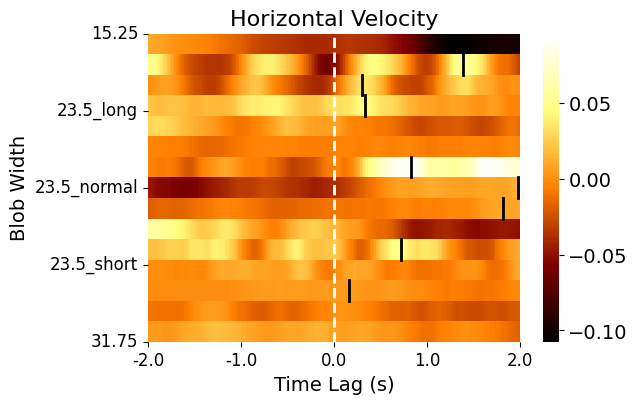

In [104]:
def find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial):
    timePoints = ccg_single_trials_trimmed.shape[1]
    
    peak_indices = np.argmax(ccg_single_trials_trimmed, axis=1)
    peak_values = np.max(ccg_single_trials_trimmed, axis=1)
    peak_indices = np.where((peak_indices > timePoints // 2) & (peak_values > 0), peak_indices, -1)
    for i, peak_index in enumerate(peak_indices):
        if peak_index != -1:
            plt.axvline(x=peak_index, color='black', linestyle='-', linewidth=2, ymin=1-(i+1)/nTrial, ymax=1-(i)/nTrial)

def plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial):
    plot_heatmap_eachTrial(ccg_single_trials_trimmed, blob_widths, lag_time)
    find_and_plot_peak_indices_eachTrial(ccg_single_trials_trimmed, nTrial)
    plt.axvline(x=lag_range,color='white',linestyle='--',linewidth=2)
    plt.show()

# Now you can use this function in your main code
plot_ccg_heatmap_with_peaks(ccg_single_trials_trimmed, blob_widths, frameRate, lag_time, nTrial)

In [105]:
# trialdict keys

trialDictSorted[0][1].keys()

dict_keys(['sigma', 'blobX', 'eyeResp', 'eyeY', 'targetY', 'eyeXY', 'targetXY', 'dynamicSigma', 'confResp', 'ccg_eye'])

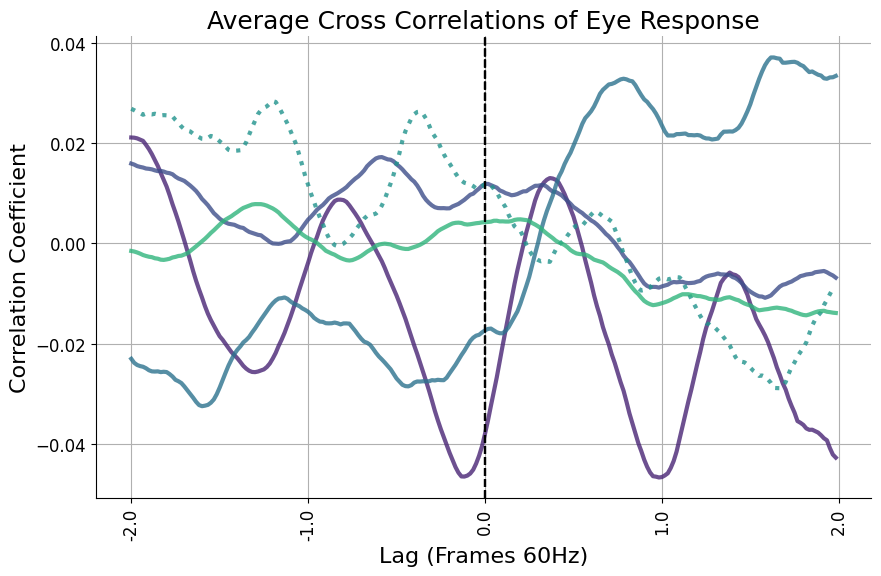

In [106]:
def plot_ccg(ccg, len_trial, steps, bw, linestyle,color):
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw, linestyle=linestyle, linewidth=3, alpha=0.8, color=color)

    # better colors for the lines
def set_x_axis_ticks(time_lag, frameRate):
    x = np.linspace(0, frameRate * time_lag * 2, 5)
    labels = np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical', fontsize=12)

def plot_vertical_line(time_lag, frameRate):
    plt.axvline(time_lag * frameRate, color='black', linestyle='--')

def set_plot_title_and_labels():
    plt.title('Average Cross Correlations of Eye Response', fontsize=16)
    plt.xlabel('Lag (Frames 60Hz)', fontsize=14)
    plt.ylabel('Correlation Coefficient', fontsize=14)

def plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean):
    len_trial = len(trialDictSorted[0][1]['blobX'])
    frameRate = 60
    time_lag = timeDelay  # seconds
    steps = int(frameRate * time_lag)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(True)
    linestyles = ['-', '-', '-', ':']
    colors = ['blue', 'green', 'red', 'purple']
    # better colors for the lines
    cmap= plt.get_cmap('viridis')
    
    colors = cmap(np.linspace(0.1, 0.65, len(blob_widths)))
    for i, bw in enumerate(blob_widths):
        ccg = ccg_blob_mean[i]
        plot_ccg(ccg, len_trial, steps, bw, linestyles[i % len(linestyles)],colors[i])
        set_x_axis_ticks(time_lag, frameRate)
        plot_vertical_line(time_lag, frameRate)
        set_plot_title_and_labels()
    ax.legend(fontsize=14)
    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    # title size
    ax.title.set_size(18)
    # y label text size
    ax.yaxis.label.set_size(16)
    # x label text size
    ax.xaxis.label.set_size(16)
    # Set x-axis limits
    #ax.set_xlim([frameRate * time_lag , frameRate * time_lag * 2])
    # off legend
    ax.legend().set_visible(False)

    plt.show()

plot_mean_ccgs(blob_widths, trialDictSorted, ccg_blob_mean)

In [107]:
def single_ccg_taker(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind][0]
    return ccg

def within_blob_ccgs(sigma=11,lag=1):
    frameRate=60
    steps=int(frameRate*lag)
    blob_ind=sigma_dict[sigma]
    ccg= ccg_single_blob[blob_ind,:,:]
    ccgs_flat=ccg.flatten()
    return ccgs_flat

def single_trial_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    trial=trialDictSorted[blob_ind][1]
    return trial
def single_blob_selector(sigma=11):
    blob_ind=sigma_dict[sigma]
    blob=trialDictSorted[blob_ind:blob_ind+nTrialPerSigma]
    return blob

both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']


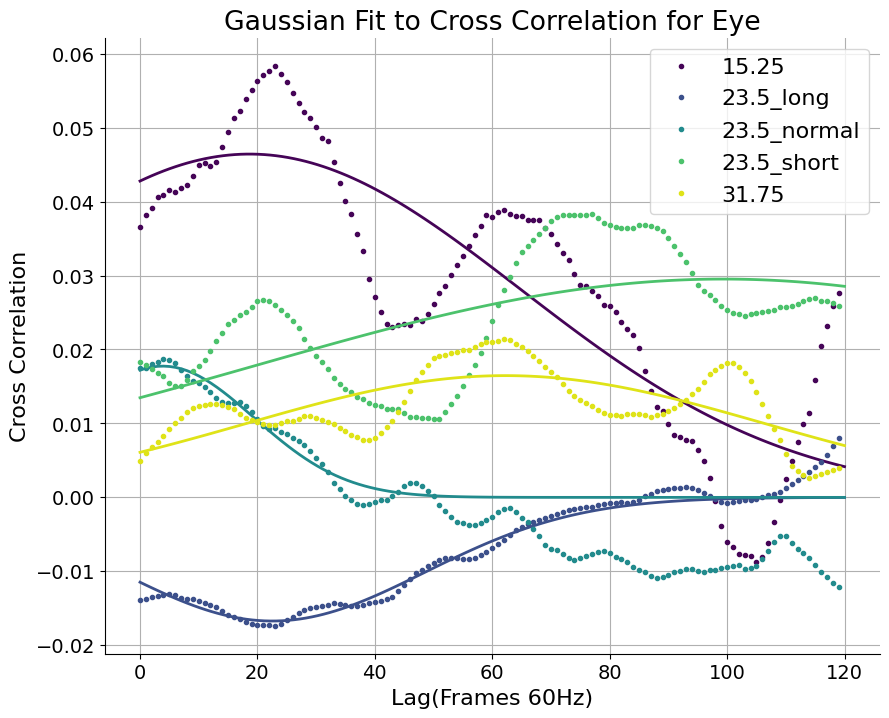

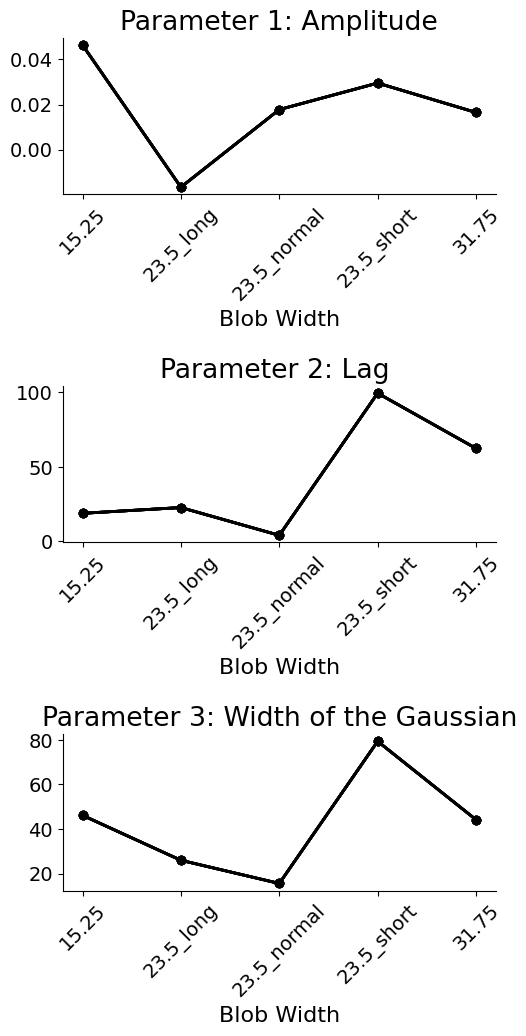

In [108]:
from sklearn.preprocessing import MinMaxScaler

frameRate=60
time_lag=timeDelay # seconds
steps=int(frameRate*time_lag)
from scipy.optimize import curve_fit
import math

blob_ind=0
ccg=ccg_blob_mean[blob_ind]
mid_point = len(ccg) // 2
ydata=ccg[mid_point:mid_point+steps]
xdata= np.linspace(0, len(ydata), len(ydata))

frameRate=60
steps=int(frameRate*time_lag)
from scipy.optimize import curve_fit
import math
dashedLine=False
blob_ind=2
ccg=ccg_blob_mean[blob_ind]
mid_point = len(ccg) // 2
ydata=ccg[mid_point:mid_point+steps]
xdata= np.linspace(0, len(ydata), len(ydata))


def gaussian(x, alpha, beta, sigma):
    eplsilon=1e-100 #small constant
    #x = x + eplsilon
    return alpha * np.exp(-(x - beta) ** 2 / (2 * (sigma ** 2)))

def double_gaussian(x, alpha1, beta1, sigma1, alpha2, beta2, sigma2): #second sum of gaussian is for handling negative correlation values
    return alpha1 * np.exp(-(x - beta1) ** 2 / (2 * (sigma1 ** 2))) + alpha2 * np.exp(-(x - beta2) ** 2 / (2 * (sigma2 ** 2)))

# def gaussian(x, alpha, beta, sigma):
#     epsilon = 1e-100  # small constant
#     #x = x + epsilon
#     return alpha * np.exp(-(np.log(x) - beta) ** 2 / (2 * sigma ** 2)) /( (x * sigma * np.sqrt(2 * np.pi))+epsilon)

def plot_data_and_fit(xdata, ydata, popt,color,alpha,lw=2):
    #plt.plot(xdata, ydata, 'b+:', label='data')
    yFit = gaussian(xdata, *popt)
    if dashedLine==True:
        plt.plot(xdata, yFit,color=color,alpha=alpha,lw=lw,linestyle=':')
    else:
        plt.plot(xdata, yFit,color=color,alpha=alpha,lw=lw,linestyle='-')
    if legendON:
        plt.legend()
    else:
        pass
    plt.title('Gaussian Fit to Cross Correlation for Eye')
    plt.xlabel('Lag(Frames 60Hz)',fontsize=16)
    plt.ylabel('Cross Correlation',fontsize=16)
    # y label text size

def plot_ccg_avg(ccg, steps, bw, color,alpha):
    mid_point = len(ccg) // 2
    ydata = ccg[mid_point:mid_point+steps]
    xdata = np.linspace(0, len(ydata), len(ydata))
    plt.plot(ccg[mid_point:mid_point+steps],'o', label=bw, markersize=3, color=color, alpha=alpha)
    #plt.legend()
    plt.title('Avarage Cross Correlations')
    # ax top and right border removed
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # add grid
    plt.grid(True)


def fit_gaussian(xdata, ydata):
    sigma_guess= np.std(ydata)
    better_sigma_guess=np.sqrt(np.abs(np.sum((xdata-np.mean(xdata))**2*ydata)/np.sum(ydata)))
    initial_guesses = [np.max(ydata), np.argmax(ydata), better_sigma_guess]
    popt, pcov = curve_fit(gaussian, xdata, ydata, p0=initial_guesses, maxfev=100000)

    return popt, pcov

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Increase the size of the plot
plt.figure(figsize=(10, 8))

# Increase the size of the text and tick labels
plt.rcParams.update({'font.size': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14})

#

# Generate a colormap
colors = cm.viridis(np.linspace(0.01, 0.95, len(blob_widths)))
lineWidth=2
LineStyle='o-'
def plot_subplots(blob_widths, data, axs, alpha, color):
    popt_list, popt_covs = process_ccg_data(blob_widths, data, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1, lw=2, shouldPlot=False)
    
    for i, hah in enumerate(colors):
        axs[0].plot(blob_widths, [popt[0] for popt in popt_list], LineStyle, alpha=alpha, color=color, lw=lineWidth)
        axs[0].set_title('Parameter 1: Amplitude')
        axs[0].set_xlabel('Blob Width')
        axs[0].set_xticklabels(['15.25', '23.5_long', '23.5_normal', '23.5_short', '31.75'], rotation=45)

        axs[1].plot(blob_widths, [popt[1] for popt in popt_list], LineStyle, alpha=alpha, color=color, lw=lineWidth)
        axs[1].set_title('Parameter 2: Lag ')
        axs[1].set_xlabel('Blob Width')
        axs[1].set_xticklabels(['15.25', '23.5_long', '23.5_normal', '23.5_short', '31.75'], rotation=45)

        axs[2].plot(blob_widths, [popt[2] for popt in popt_list], LineStyle, alpha=alpha, color=color, lw=lineWidth)
        axs[2].set_title('Parameter 3: Width of the Gaussian')
        axs[2].set_xlabel('Blob Width')
        axs[2].set_xticklabels(['15.25', '23.5_long', '23.5_normal', '23.5_short', '31.75'], rotation=45)

def process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=0.5,lw=2, shouldPlot=True):
    popt_list = []
    pcov_list = []
    for i, bw in enumerate(blob_widths): 
        ccg = ccg_blob_mean[i]
        mid_point = len(ccg) // 2
        ydata = ccg[mid_point:mid_point+steps]
        xdata = np.linspace(0, len(ydata), len(ydata))
        popt, pcov = fit_gaussian(xdata, ydata)

        if shouldPlot:
            if plotPointsCCGAvg:
                plot_ccg_avg(ccg, steps, bw, colors[i],alpha=alpha)
            plot_data_and_fit(xdata, ydata, popt,color=colors[i],alpha=alpha,lw=lw)
        else:
            pass
        popt_list.append(popt)
        pcov_list.append(pcov)
    return popt_list, pcov_list
legendON=True
plotPointsCCGAvg=True


fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data("dataMeta_both", "p6")

# trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
#                                                       mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)
# ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, dv,iv)


process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=1,lw=2)


fig, axs = plt.subplots(3, 1)
# Increase the size of the plot
fig.set_size_inches(8, 12)
# increase the space between the plots

fig.tight_layout(pad=7.0)

# Remove top and right borders
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#fig.tight_layout(pad=40.0)
plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=1,color='black')


In [18]:
blob_widths

array(['15.25', '23.5_long', '23.5_normal', '23.5_short', '31.75'],
      dtype='<U32')

In [19]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_5652\2822273860.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [20]:
file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
file_list[0]

'p0_both_185776_continous_psych_2024-03-11_11h48.21.062.mat'

In [21]:
fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data(folderName, 'p'+str(1))


NameError: name 'folderName' is not defined

both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p1_both_continous_psych_2024-05-15_16h41.53.384.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p2_both_continous_psych_2024-05-15_17h22.30.956 - Copy.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p3_both_continous_psych_2024-05-16_13h17.23.780.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p4_both_continous_psych_2024-05-16_16h45.48.601.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p5_both_continous_psych_2024-05-17_11h02.59.005.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p6_both_continous_psych_2024-05-17_11h41.16.312.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p7_both_continous_psych_2024-05-17_13h35.58.817.mat
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '

c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning:

overflow encountered in multiply



eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p2_eye_continous_psych_2024-05-16_16h18.23.847.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p3_eye_continous_psych_2024-05-16_13h33.25.906.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p4_eye_continous_psych_2024-05-16_16h34.55.421.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p5_eye_continous_psych_2024-05-17_11h15.36.431.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p6_eye_continous_psych_2024-05-17_11h32.12.486.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p7_eye_continous_psych_2024-05-17_13h20.23.546.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p8_eye_continous_psych_2024-05-17_14h36.30.430.mat
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta

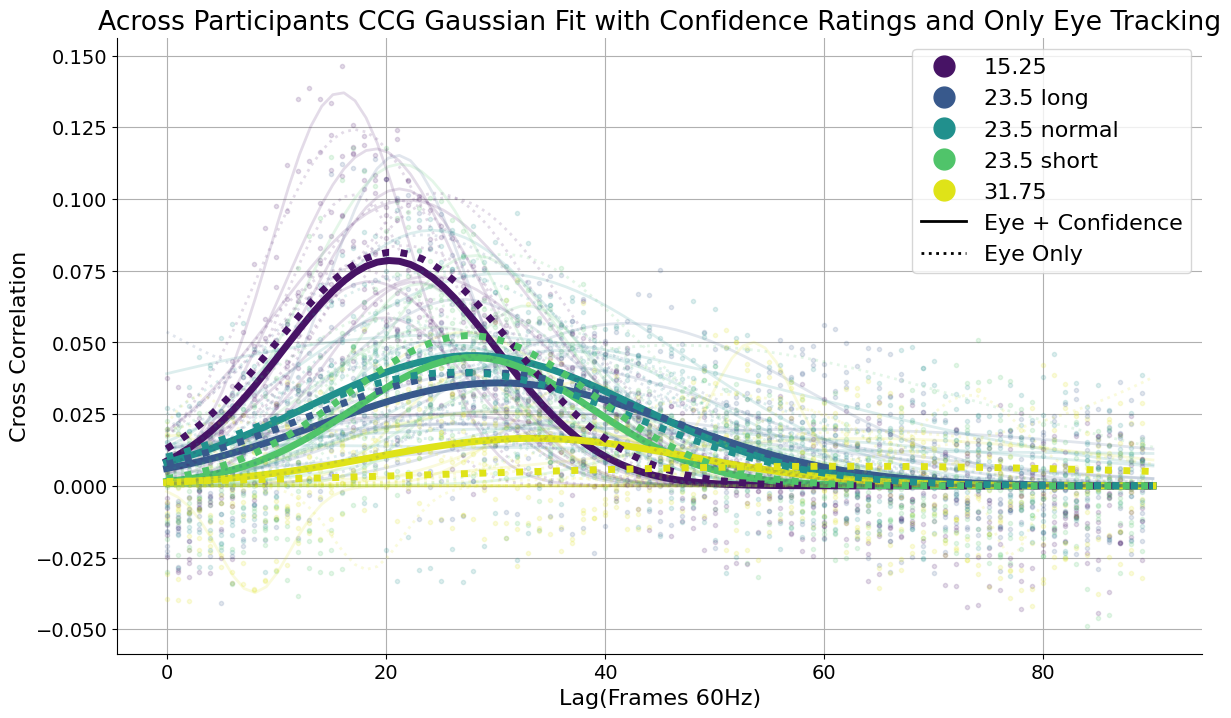

In [22]:
# file list in data_both
import matplotlib.lines as mlines

file_list = os.listdir("data_both")
from scipy.optimize import curve_fit
import math
frameRate=60
time_lag=timeDelay # seconds
steps=int(frameRate*time_lag)
# Create the plot before the loop
#fig, ax = plt.subplots()
plt.figure(figsize=(14,8))
avgCCGBlobMeansAcrossParticipants = []
avgCCGSingleTrialsAcrossParticipants=[]
avgCCGSingleBlobsAcrossParticipants=[]
avgCCGSingleTrialsTrimmedAcrossParticipants=[]
avgCCGSingleBlobsTrimmedAcrossParticipants=[]

legendON=False
dashedLine=False
colors = cm.viridis(np.linspace(0.05, 0.95, len(blob_widths)))
labels = ['15.25', '23.5 long', '23.5 normal','23.5 short', 31.75]  # Adjust as needed

# Create Line2D objects for the legend
# Add additional Line2D objects for the eye and mouse responses
lines = [mlines.Line2D([], [], color=color, marker='o', markersize=15, label=label, linestyle='None') for color, label in zip(colors, labels)]
eye_line = mlines.Line2D([], [], color='black', lw=2, label='Eye + Confidence')
mouse_line = mlines.Line2D([], [], color='black', lw=2, linestyle=':', label='Eye Only')

lines += [eye_line, mouse_line]
for fileName in ["eyeResp", "mouseResp"]:

    avgCCGBlobMeansAcrossParticipants = []
    avgCCGSingleTrialsAcrossParticipants=[]
    avgCCGSingleBlobsAcrossParticipants=[]
    avgCCGSingleTrialsTrimmedAcrossParticipants=[]
    avgCCGSingleBlobsTrimmedAcrossParticipants=[]
    if fileName == "eyeResp":
        folderName="dataMeta_both"
        dashedLine=False
        lw=5
        LineStyle='o-'
        paramColor="orangered"
    elif fileName == "mouseResp":
        folderName="dataMeta_eye"
        #colors = cm.Reds(np.linspace(0.1, 0.65, len(file_list)))
        # reds
        dashedLine=True
        lw=5
        paramColor="forestgreen"
        LineStyle='o--'
    for fileN in range(1,len(file_list)-1):
        randomColorCode = np.random.rand(3,)
        #colors = cm.viridis(np.linspace(0.1, 0.65, len(blob_widths)))

        fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data(folderName, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
                                                      mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)

        ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, dv,iv)
        avgCCGBlobMeansAcrossParticipants.append(ccg_blob_mean)
        avgCCGSingleTrialsAcrossParticipants.append(ccg_single_trials)
        avgCCGSingleBlobsAcrossParticipants.append(ccg_single_blob)
        avgCCGSingleTrialsTrimmedAcrossParticipants.append(ccg_single_trials_trimmed)
        avgCCGSingleBlobsTrimmedAcrossParticipants.append(ccg_blob_mean_trimmed)

        # plot the average CCG for each participant

        process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=0.15)


    #plt.legend()
    #plt.show()

    # now plot the average CCG across all participants
    avgCCGBlobMeansAcrossParticipants = np.array(avgCCGBlobMeansAcrossParticipants)
    avgCCGSingleTrialsAcrossParticipants = np.array(avgCCGSingleTrialsAcrossParticipants)
    avgCCGSingleBlobsAcrossParticipants = np.array(avgCCGSingleBlobsAcrossParticipants)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.array(avgCCGSingleTrialsTrimmedAcrossParticipants)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.array(avgCCGSingleBlobsTrimmedAcrossParticipants)

    avgCCGBlobMeansAcrossParticipants = np.mean(avgCCGBlobMeansAcrossParticipants, axis=0)
    avgCCGSingleTrialsAcrossParticipants = np.mean(avgCCGSingleTrialsAcrossParticipants, axis=0)
    avgCCGSingleBlobsAcrossParticipants = np.mean(avgCCGSingleBlobsAcrossParticipants, axis=0)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.mean(avgCCGSingleTrialsTrimmedAcrossParticipants, axis=0)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.mean(avgCCGSingleBlobsTrimmedAcrossParticipants, axis=0)
    plotPointsCCGAvg=False

    alpha=1
    legendON=False
    process_ccg_data(blob_widths, avgCCGBlobMeansAcrossParticipants, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots,alpha=1,lw=lw)

    legendON=False
    plt.title('Across Participants CCG Gaussian Fit with Confidence Ratings and Only Eye Tracking')

# Add the legend at the end of your code
plt.legend(handles=lines, loc='best')
plt.show()
plotPointsCCGAvg=True


""" Figure description

Figure 13: Average CCGs for Eye Only and Eye + Confidence Ratings

This figure shows the average cross-correlation functions (CCGs) for the eye tracking data only and the eye tracking data with confidence ratings. The CCGs are averaged across all participants. The CCGs are fitted with a Gaussian function. The amplitude, lag, and width of the Gaussian function are plotted against the blob width. The error bars represent the standard deviation across participants. The legend shows the blob width for each line. The red lines represent the eye tracking data with confidence ratings, and the green lines represent the eye tracking data only.


"""


both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p1_both_continous_psych_2024-05-15_16h41.53.384.mat
[array([ 0.09961973, 22.02436031, 12.08024503]), array([ 0.06506923, 26.81764378, 11.50413816]), array([ 0.07403196, 30.28617691, 17.08439937]), array([ 0.05531486, 24.63267687, 11.600739  ]), array([ 0.03918129, 27.29873274,  6.01811192])]
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p2_both_continous_psych_2024-05-15_17h22.30.956 - Copy.mat
[array([ 0.11751962, 19.0338886 ,  8.13096837]), array([ 0.11525597, 21.07775971,  6.50507686]), array([ 0.08911716, 24.2323261 , 12.40276211]), array([ 0.11221122, 21.35851117,  8.80823775]), array([ 0.05356416, 27.18291663,  9.78781928])]
both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p3_both_continous_psych_2024-05-16_13h17.23.780.mat
[array([ 0.10354602, 21.25498764,  8.44439639]), array([ 0.05665089, 41.9087503 , 16.03923965]), array([ 0

ValueError: too many values to unpack (expected 1)

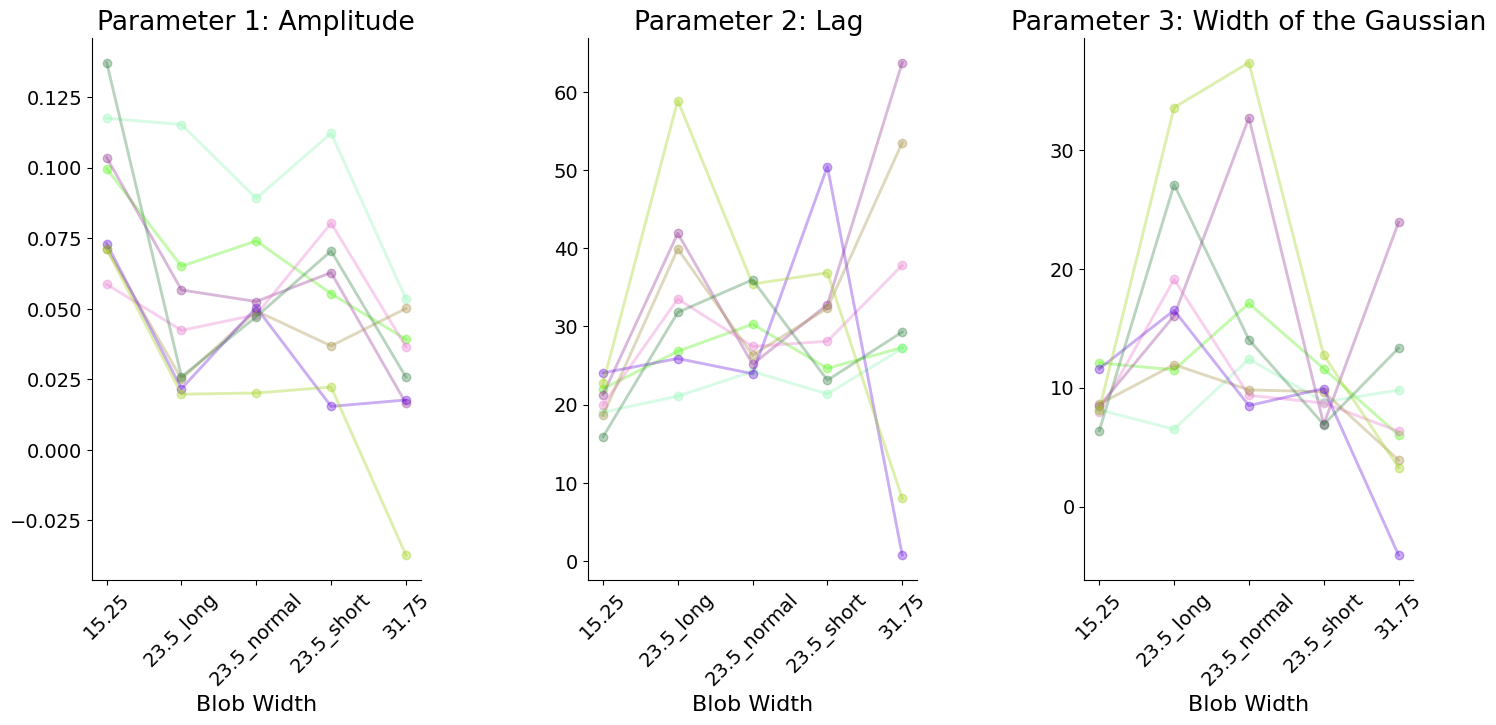

In [27]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(1,3)
# Increase the size of the plot
fig.set_size_inches(16, 8)
# increase the space between the plots

fig.tight_layout(pad=5.0)

# Remove top and right borders
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# plot the average CCG subplot parameters for each participant

GaussianFitParams = []
time_lag=2

for fileName in ["eyeResp", "mouseResp"]:

    avgCCGBlobMeansAcrossParticipants = []
    avgCCGSingleTrialsAcrossParticipants=[]
    avgCCGSingleBlobsAcrossParticipants=[]
    avgCCGSingleTrialsTrimmedAcrossParticipants=[]
    avgCCGSingleBlobsTrimmedAcrossParticipants=[]
    if fileName == "eyeResp":
        folderName="dataMeta_both"
        dashedLine=False
        lw=5
        LineStyle='o-'
        paramColor="orangered"
    elif fileName == "mouseResp":
        folderName="dataMeta_eye"
        #colors = cm.Reds(np.linspace(0.1, 0.65, len(file_list)))
        # reds
        dashedLine=True
        lw=5
        paramColor="forestgreen"
        LineStyle='o--'
    for fileN in range(1,len(file_list)-1):
        randomColorCode = np.random.rand(3,)
        #colors = cm.viridis(np.linspace(0.1, 0.65, len(blob_widths)))

        fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data(folderName, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
                                                      mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)

        ccg_blob_mean_trimmed, ccg_single_trials_trimmed, ccg_blob_mean, ccg_single_blob,ccg_single_trials= process_ccgs(trialDictSorted, blob_widths, nTrialPerSigma, len_trial, lag_range, dv,iv)
  
        popt_list,popt_covs=process_ccg_data(blob_widths, ccg_blob_mean, steps, plot_ccg_avg, fit_gaussian, plot_data_and_fit, plot_subplots, alpha=0.05,lw=2, shouldPlot=False)
        print(popt_list)

        def has_element_gt_1000(my_list):
            for element in my_list:
                for el in element:
                    if el> 100 or el < -100:

                        return True
            return False
        if has_element_gt_1000(popt_list)==True:
            popt_list = [0,0,0]
            print("Gaussian Fit Failed for Participant: ", fileIs)
            continue
            
        else:
            plot_subplots(blob_widths, ccg_blob_mean, axs,alpha=0.08,color=randomColorCode)

        
        GaussianFitParams.append(popt_list)
        avgCCGBlobMeansAcrossParticipants.append(ccg_blob_mean)
        avgCCGSingleTrialsAcrossParticipants.append(ccg_single_trials)
        avgCCGSingleBlobsAcrossParticipants.append(ccg_single_blob)
        avgCCGSingleTrialsTrimmedAcrossParticipants.append(ccg_single_trials_trimmed)
        avgCCGSingleBlobsTrimmedAcrossParticipants.append(ccg_blob_mean_trimmed)
# now plot the average CCG across all participants
    avgCCGBlobMeansAcrossParticipants = np.array(avgCCGBlobMeansAcrossParticipants)
    avgCCGSingleTrialsAcrossParticipants = np.array(avgCCGSingleTrialsAcrossParticipants)
    avgCCGSingleBlobsAcrossParticipants = np.array(avgCCGSingleBlobsAcrossParticipants)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.array(avgCCGSingleTrialsTrimmedAcrossParticipants)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.array(avgCCGSingleBlobsTrimmedAcrossParticipants)

    avgCCGBlobMeansAcrossParticipants = np.mean(avgCCGBlobMeansAcrossParticipants, axis=0)
    avgCCGSingleTrialsAcrossParticipants = np.mean(avgCCGSingleTrialsAcrossParticipants, axis=0)
    avgCCGSingleBlobsAcrossParticipants = np.mean(avgCCGSingleBlobsAcrossParticipants, axis=0)
    avgCCGSingleTrialsTrimmedAcrossParticipants = np.mean(avgCCGSingleTrialsTrimmedAcrossParticipants, axis=0)
    avgCCGSingleBlobsTrimmedAcrossParticipants = np.mean(avgCCGSingleBlobsTrimmedAcrossParticipants, axis=0)

    
    lineWidth=4
    plot_subplots(blob_widths, avgCCGBlobMeansAcrossParticipants, axs,alpha=1,color=paramColor)
    lineWidth=2
# custom legend for eye and mouse response
eye_line = mlines.Line2D([], [], color='orangered', lw=2, label='Eye Response')
mouse_line = mlines.Line2D([], [], color='forestgreen', lw=2, linestyle=':', label='Mouse Response')
lines = [eye_line, mouse_line]
plt.legend(handles=lines, loc='best')

plt.show()

##
"""

We use this fitting method to retrieve each participant's individual parameters for the cross correlogram. 
Using these parameters we can then compare the individual differences in the cross correlogram and see if there are any differences between the two groups. 
In the figure 

By applying a simple ANOVA test we can then see if there are any significant differences between eye tracking and mouse tracking in the cross correlogram. Here in the figure below you can see the fitting of all 10 participants in the study using the same fitting method as above.

"""




## - Save fitting parameters

In [ ]:
import os
os.listdir()

['.git',
 'conditions.ipynb',
 'conditions.npy',
 'create_conditions.py',
 'dva_to_pix.py',
 'recorded',
 'cont_psych_simpler_.py',
 '__pycache__',
 'lam.py',
 '1_data.csv',
 'data',
 'analysis_primier.ipynb',
 'analysis_m.m',
 'README.md',
 'analysis_26092023.ipynb',
 'tracking2graphs.m',
 'negLogLikelihoodr.m',
 'data.mat',
 'example.fig',
 'omer_pilot_2.mat',
 'audio_cue.py',
 'panning_beep_beep_beep.wav',
 'beep_beep_beep.wav',
 'right.wav',
 'left.wav',
 'audio_player_psychopy.py',
 'builder_coder',
 'example_trial.mp4',
 'audio_visual_target_tracking.py',
 'continous_psychophysics_moseTrackerDumb.py',
 '.vscode',
 'simple_tracker_experiment_0.py',
 'pyimagesearch',
 'simple_tracker_experiment_openCv.py',
 'Non included tuts',
 'eye_tracking_1.py',
 'Eye_tracking_continuous_psych.py',
 'et_data.EDF',
 'NoiseGenerator.py',
 'lqg straub analysis adaptation.ipynb',
 'data_eye',
 'data_both',
 'p0_eye_180076_continous_psych_2024-03-08_10h28.12.835.mat',
 'analysis_eye_mouse.ipynb',
 '

In [ ]:
# import pandas as pd
# df=pd.read_csv('df_final.csv')

In [ ]:
# # summary df_all
# from plotly import __version__
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
# import plotly.offline as pyo
# import plotly.graph_objs as go
# from plotly.offline import iplot
# from scipy import stats
# import math

In [ ]:
respMode= np.repeat("eyeOnly",60)
respMode[30:]= "mouse"
respMode.shape


(60,)

In [ ]:
GaussianFitParams = np.array(GaussianFitParams)
amplitude = GaussianFitParams[:,:,0]
lag = GaussianFitParams[:,:,1]
width = GaussianFitParams[:,:,2]
respMode= np.repeat("eyeOnly",30)
import pandas as pd

df = pd.DataFrame(data=amplitude, columns=blob_widths)

# Reshape the DataFrame from wide format to long format
df_amplitude = df.melt(value_vars=blob_widths, var_name='blob_widths', value_name='amplitude')
df_amplitude

# Create and reshape the 'lag' DataFrame

df_lag = pd.DataFrame(data=lag, columns=blob_widths)
df_lag_melted = df_lag.melt(value_vars=blob_widths, var_name='blob_widths', value_name='lag')

# Create and reshape the 'width' DataFrame
df_width = pd.DataFrame(data=width, columns=blob_widths)
df_width_melted = df_width.melt(value_vars=blob_widths, var_name='blob_widths', value_name='width')

# Concatenate the 'amplitude', 'lag', and 'width' DataFrames
df_final = pd.concat([df_amplitude, df_lag_melted['lag'], df_width_melted['width']], axis=1)
df_final

df_final['participant'] = np.tile(np.arange(0,10,1),6)
respMode= np.repeat("eyeOnly",60)
respMode[30:]= "mouse"
respMode.shape
df_final['respMode'] = respMode





In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


# Fit the ANOVA models
model_amp = ols('amplitude ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()
model_lag = ols('lag ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()
model_width = ols('width ~ C(blob_widths) + C(respMode) + C(blob_widths):C(respMode)', data=df_final).fit()

# Perform the ANOVAs
anova_results_amp = anova_lm(model_amp)
anova_results_lag = anova_lm(model_lag)
anova_results_width = anova_lm(model_width)

print(anova_results_amp)
print(anova_results_lag)
print(anova_results_width)

                              df    sum_sq   mean_sq          F        PR(>F)
C(blob_widths)               4.0  0.027342  0.006835  14.088078  6.157939e-08
C(respMode)                  1.0  0.000137  0.000137   0.283311  5.967227e-01
C(blob_widths):C(respMode)   4.0  0.001684  0.000421   0.867572  4.894150e-01
Residual                    54.0  0.026201  0.000485        NaN           NaN
                              df        sum_sq      mean_sq         F  \
C(blob_widths)               4.0   5315.784417  1328.946104  7.085170   
C(respMode)                  1.0      1.906397     1.906397  0.010164   
C(blob_widths):C(respMode)   4.0     30.558665     7.639666  0.040730   
Residual                    54.0  10128.633007   187.567278       NaN   

                              PR(>F)  
C(blob_widths)              0.000116  
C(respMode)                 0.920070  
C(blob_widths):C(respMode)  0.996753  
Residual                         NaN  
                              df       sum_sq    

# Kalman

In [ ]:
from scipy.sparse import diags
import scipy.optimize as opt
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    # Compute nLL using list comprehension
    nLL = -sum(-1 / (2 * k**2 * rr) * np.dot((np.dot(d, Xhat[:, i]) - k * X[:, i]).T, np.dot(d, Xhat[:, i]) - k * X[:, i]) - N / 2 * np.log(rr) - N * np.log(k) for i in range(numTrials))

    return nLL
from scipy.optimize import minimize


In [ ]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

both
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_both\p1_both_continous_psych_2024-05-15_16h41.53.384.mat
1
['31.75' '23.5_short' '23.5_normal' '23.5_long' '15.25']
Optimal value for observation noise variance is 3.403285091821605
Optimal value for observation noise variance is 3.0784112353298383
Optimal value for observation noise variance is 2.7323367709421738
Optimal value for observation noise variance is 2.804410366391139
Optimal value for observation noise variance is 2.831930395005545
eye
15 5 3 ['15.25' '23.5_long' '23.5_normal' '23.5_short' '31.75']
dataMeta_eye\p10_eye_continous_psych_2024-05-17_15h32.37.684.mat
1
['31.75' '23.5_short' '23.5_normal' '23.5_long' '15.25']
Optimal value for observation noise variance is 6.761614267319699
Optimal value for observation noise variance is 3.288661434866188
Optimal value for observation noise variance is 3.3094546371934452
Optimal value for observation noise variance is 5.49024460549866
Optimal value for 

' \nTo further retrieve a single better measure of visual uncertainty about the target we fit the Kalman filter to the position data. As we have described in the introduction Kalman filter uses a moving avarage like Bayesian algorithm to estimate the future states of the system. Here we reverse correlate this model using fitting with the given responses and try to retrieve observed noise variance which we refer as positional uncertainty of the target. Here after we will symbolize this parameter as R. \nKalman filter in the tracking task, provided us two positional values for each frame. The first one is the target position and the second one is the response position of the participant. We used the target position as the true position of the target and the response position as the observed position of the target. We then calculated the positional uncertainty of the target for each blob width using the Kalman filter. \nHow do we do that? We first \n\n\n Figure: Positional Uncertainty for

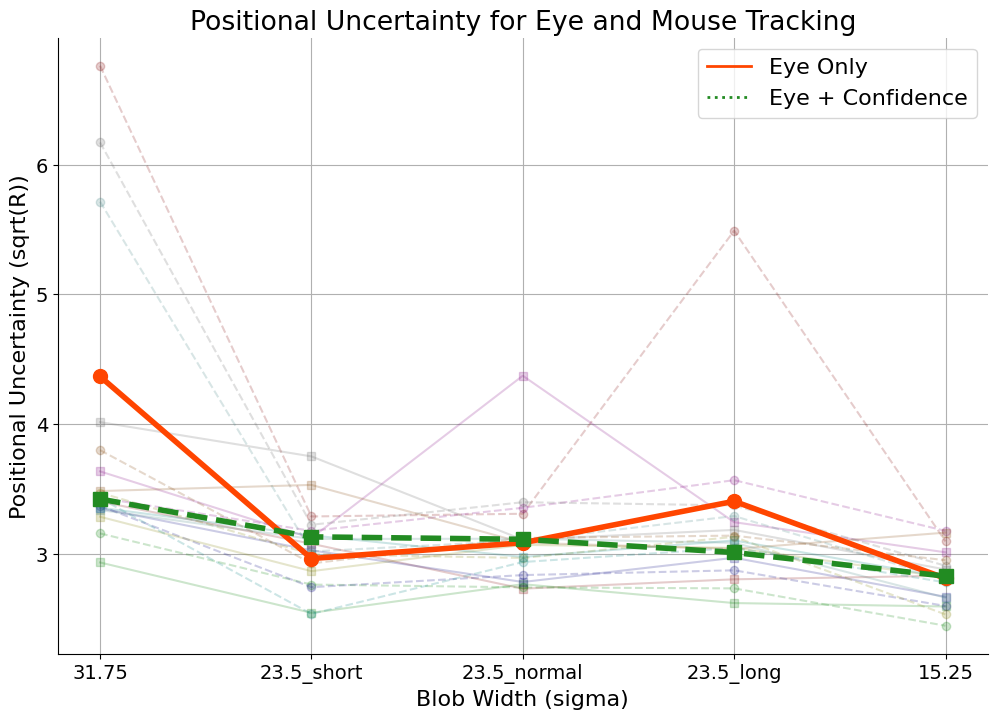

In [ ]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")
rValMouse = []
rValEye = []
plt.figure(figsize=(12,8))
plt.title('Positional Uncertainty for Eye and Mouse Tracking')
for fileN in range(1,10):
    randomColorCode = np.random.rand(3,)
    for dataType in ["dataMeta_both", "dataMeta_eye"]:
        r_values_eye = []
        r_values_both = []
        
        fileIs,sigma, dynamicSigma, confRate,target,eyeResp,confRateReal,dynamicSigmaReal, nTrial, nSigma, nTrialPerSigma, blob_widths,combinedEyeRespXY,combinedTargetPosXY,eyeRespY,targetY = load_and_process_data(dataType, 'p'+str(fileN))
        print(fileIs)
        trialDictSorted, tmp_trial = create_sorted_trial_dict(nTrial, dynamicSigma=dynamicSigma, confRate=confRate, sigma=sigma, fileIs=fileIs,target=target,eyeResp=eyeResp, 
                                                      mouseResp=None, dynamicSigmaReal=dynamicSigmaReal, confRateReal=confRateReal)
        print(fileN)
        X = target
        # if dataType == "dataMeta_both":
        #     Y = mouseResp
        # else:
        #     Y = eyeResp
        #     #Y = smooth_data(Y)
        Y=eyeResp
        nLLs = []
        i=0
        # Initialize arrays to store results
        r_values = np.zeros(len(blob_widths))
        fval_values = np.zeros(len(blob_widths))
        # Plot setup
        lag=12
        clip=60

        Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
        Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
        results=[]
        Q=1
        # calculate intirial Guess for Q 
        rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
        # sigmas is reversed unique values of sigma
        sigmas = np.unique(sigma)[::-1]
        print(sigmas)
        for i in range(len(sigmas)):
            index = [s == sigmas[i] for s in sigma]
            index=np.array(index).flatten()
            #calculate Q for each sigma as a variance of displacement
            result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
            results.append(result)
            # # Store optimization results
            r_values[i] = np.sqrt(result.x[0])
            fval_values[i] = result.fun
            print('Optimal value for observation noise variance is ' + str(r_values[i]))
            # # Plot the result
            if dataType=="data_both":    
                #plt.semilogx(sigmas[i], r_values[i], 's', linewidth=3, markersize=13, label=f'sigma={sigmas}',color=colors[fileN], alpha=0.7)
                #r_values_both.append(r_values)
                pass
            else:
                pass
                #plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=15, label=f'sigma={sigmas}',color=colors[fileN], alpha=0.7)
                #r_values_eye.append(r_values)
        if dataType=="dataMeta_both":
            plt.plot(sigmas, r_values, 'k-',color=colors[fileN],label=f'sigma={sigmas}',marker='s',alpha=0.2)
        else:
            plt.plot(sigmas, r_values, 'k--',color=colors[fileN],label=f'sigma={sigmas}',marker='o',alpha=0.2)
        
        #y ticks only show 11, 17, 25
        plt.xticks(sigmas)
        # remove spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.grid(True)

        if dataType=="dataMeta_both":
            rValMouse.append(r_values)
            
        else:
            rValEye.append(r_values)
        
#plot avaraged r values for eye

rValEye=np.array(rValEye)
rValMouse=np.array(rValMouse)
rValEyeMean=np.mean(rValEye,axis=0)
rValMouseMean=np.mean(rValMouse,axis=0)
print(rValEyeMean)
print('sigmas is ', sigmas)
plt.plot(sigmas, rValEyeMean, 'k-',color='orangered',label=f'Eye Only',marker='o',markersize=10,lw=4)
plt.plot(sigmas, rValMouseMean, 'k--',color='forestgreen',label=f'Eye + Confidence',marker='s',markersize=10,lw=4)
eye_line = mlines.Line2D([], [], color='orangered', lw=2, label='Eye Only')
mouse_line = mlines.Line2D([], [], color='forestgreen', lw=2, linestyle=':', label='Eye + Confidence')
lines = [eye_line, mouse_line]
plt.legend(handles=lines, loc='best')

plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')



""" 
To further retrieve a single better measure of visual uncertainty about the target we fit the Kalman filter to the position data. As we have described in the introduction Kalman filter uses a moving avarage like Bayesian algorithm to estimate the future states of the system. Here we reverse correlate this model using fitting with the given responses and try to retrieve observed noise variance which we refer as positional uncertainty of the target. Here after we will symbolize this parameter as R. 
Kalman filter in the tracking task, provided us two positional values for each frame. The first one is the target position and the second one is the response position of the participant. We used the target position as the true position of the target and the response position as the observed position of the target. We then calculated the positional uncertainty of the target for each blob width using the Kalman filter. 
How do we do that? We first 


 Figure: Positional Uncertainty for Eye and Mouse Tracking
figure captions:
The figure shows the positional uncertainty of the eye and mouse tracking for different blob widths. The x-axis represents the blob width (sigma), and the y-axis represents the positional uncertainty (sqrt(R)). The black solid line represents the positional uncertainty for the eye tracking, and the black dashed line represents the positional uncertainty for the mouse tracking.
The positional uncertainty of the eye tracking is higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking. The positional uncertainty of both eye and mouse tracking increases with increasing blob width, indicating that the response to the motion of the target is more variable and less consistent for larger blob widths. The positional uncertainty of the eye tracking is consistently higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking.

Figure description in text:

The figure shows the positional uncertainty of the eye and mouse tracking for different blob widths.
The x-axis represents the blob width (sigma), and the y-axis represents the positional uncertainty (sqrt(R)).
The black solid line represents the positional uncertainty for the eye tracking, and the black dashed line represents the positional uncertainty for the mouse tracking.


Figure 9 shows the positional uncertainty of the eye and mouse tracking for different blob widths. The positional uncertainty of the eye tracking is consistently higher than the mouse tracking for all blob widths, indicating that the eye tracking has a higher variability in the response to the motion of the target compared to the mouse tracking. 



"""

In [ ]:
df.describe()
df["participant"]= df["participant"].astype("category")
df["blob_widths"]=df["blob_widths"].astype("category")
df.to_csv('df_final.csv',index=False)

In [ ]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eye'].rename(columns={'lag': 'lag_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'lag': 'lag_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='lag_eye', y='lag_mouse', data=merged_df, hue='blob_widths')
plt.title('Lag of Eye Response vs Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')

In [ ]:

# Create separate dataframes for 'eyeResp' and 'mouseResp'
eye_df = df[df['respMode']=='eye'].rename(columns={'amplitude': 'peak_eye'})
mouse_df = df[df['respMode']=='mouse'].rename(columns={'amplitude': 'peak_mouse'})

# Merge the dataframes on 'participant' and 'blob_widths'
merged_df = pd.merge(eye_df, mouse_df, on=['participant', 'blob_widths'])

# Plot the data
plt.figure(figsize=(10,6))
sns.scatterplot(x='peak_eye', y='peak_mouse', data=merged_df, hue='blob_widths')
plt.title('Peak of Eye Response vsf Mouse Response by Blob Widths')
plt.xlabel('Eye Response')
plt.ylabel('Mouse Response')